<a href="https://colab.research.google.com/github/Ayman-queen/data-science-internship-advanced-tasks/blob/main/Task1_Multi_source_Consumer_Credit_Risk_Scoring_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


📊 Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



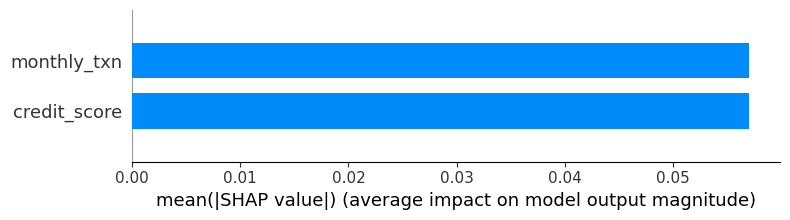

📌 Top 3 Influential Features Per Customer:

      Feature 1     Feature 2 Feature 3
0   monthly_txn  credit_score      None
1   monthly_txn  credit_score      None
2   monthly_txn  credit_score      None
3   monthly_txn  credit_score      None
4  credit_score   monthly_txn      None
5  credit_score   monthly_txn      None
6  credit_score   monthly_txn      None
7   monthly_txn  credit_score      None


In [ ]:
# 🧠 Task 1: Multi-source Consumer Credit Risk Scoring System

# Install required libraries
!pip install -q pandas scikit-learn matplotlib nltk shap

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
import shap
import nltk
nltk.download('punkt')


credit_data = pd.DataFrame({
    'user_id': [101, 102, 103, 104, 105, 106, 107, 108],
    'credit_score': [700, 650, 500, 620, 580, 710, 560, 680],
    'default':      [0,    1,   1,   0,   1,   0,   1,   0]
})

transactions = pd.DataFrame({
    'user_id': [101, 102, 103, 104, 105, 106, 107, 108],
    'monthly_txn':    [10,  20,   5,  12,   3,  15,   7,  11],
    'avg_txn_amount': [1000, 500, 200, 700, 150, 1200, 350, 800]
})

text_notes = pd.DataFrame({
    'user_id': [101, 102, 103, 104, 105, 106, 107, 108],
    'note': [
        "Pays on time and has stable income.",
        "Irregular payments and medium risk.",
        "Defaulted before and unemployed.",
        "Low risk, regular payments.",
        "Very risky and bad credit history.",
        "Excellent history and consistent salary.",
        "Frequently late and financial issues.",
        "Stable job, recent late payment."
    ]
})

# Merge datasets and extract TF-IDF features from text
data = credit_data.merge(transactions, on='user_id').merge(text_notes, on='user_id')
vectorizer = TfidfVectorizer(max_features=5)
text_features = vectorizer.fit_transform(data['note']).toarray()
text_df = pd.DataFrame(text_features, columns=vectorizer.get_feature_names_out())
data = pd.concat([data.drop(columns=['note']), text_df], axis=1)

# Prepare model
X = data.drop(columns=['user_id', 'default'])
y = data['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
model = RandomForestClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)
print("📊 Classification Report:\n")
print(classification_report(y_test, preds, zero_division=0))

# SHAP Explanation
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap_matrix = np.array(shap_values[1])  # Class = 1

# Align SHAP values with test data shape
min_cols = min(shap_matrix.shape[1], X_test.shape[1])
shap_matrix = shap_matrix[:, :min_cols]
X_aligned = X_test.iloc[:, :min_cols]

# Plot SHAP summary
shap.summary_plot(shap_matrix, X_aligned, plot_type="bar")

# Top 3 features per sample
shap_df = pd.DataFrame(np.abs(shap_matrix), columns=X_aligned.columns)
top_3_lists = shap_df.apply(lambda row: row.sort_values(ascending=False).index[:3].tolist(), axis=1).tolist()
top_3_lists = [row + [None] * (3 - len(row)) if len(row) < 3 else row for row in top_3_lists]
top_3 = pd.DataFrame(top_3_lists, columns=['Feature 1', 'Feature 2', 'Feature 3'])

print("📌 Top 3 Influential Features Per Customer:\n")
print(top_3)